# Regression tree stumps

A regression tree stump is a tree with a decision node at the root and two predictor leaves. The leaves predict the average of the target values held by that leaf, assuming we are [minimizing the mean squared error (MSE) loss function](https://explained.ai/gradient-boosting/L2-loss.html#sec:2.5).

To keep things simple, this example assumes that only a single predictor variable, $x$, is associated with the target variable, $y$.

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from dtreeviz.trees import *
from lolviz import *

import numpy as np
import pandas as pd

## Define decision and leaf nodes and how to predict

Because decision and predictor nodes have different behavior, it makes sense to create two different classes.  To make a prediction for test vector $X$, a decision node compares the predictor variable (feature) $x_i$ against a split value. (We only have one predictor here so we don't bother recording which feature a node is testing.) The split value will be chosen from the range of $x_i$ during training (see below).

In [5]:
class DecisionNode:
    def __init__(self,split): # split chosen from x values
        self.split = split
    def predict(self,x):
        if x < self.split:
            return self.left.predict(x)
        return self.right.predict(x)

class LeafNode:
    def __init__(self,y,left=None,right=None):
        self.y = y
    def predict(self, x): # Predictions are the means of subregions (x ignored in leaf)
        return np.mean(self.y)    

Given these definitions, let's manually build a stump and make a prediction or two.

In [6]:
root = DecisionNode(900)                 # split on x at 900
root.left = LeafNode([1160, 1200, 1280]) # 3 y values in leaf
root.right = LeafNode([1450,2000])

x = 900
y_pred = root.predict(x)
print(f"{x} => {y_pred:.1f} (avg [1450,2000] is {np.mean([1450,2000])})")

x = 890
y_pred = root.predict(x)
print(f"{x} => {y_pred:.1f} (avg [1450,2000] is {np.mean([1450,2000])})")

900 => 1725.0 (avg [1450,2000] is 1725.0)
890 => 1213.3 (avg [1450,2000] is 1725.0)


## Fit a stump to single-var x and target y

In [7]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    loss, split = find_best_split(x,y)
    root = DecisionNode(split)
    root.left = LeafNode(y[x<split])
    root.right = LeafNode(y[x>=split])
    return root
        
def find_best_split(x,y):
    best_loss = np.inf
    best_split = -1
    print(f"find_best_split in x={list(x)}")
    for v in x[1:]: # try all possible x values
        lefty = y[x<v].values
        righty = y[x>=v].values
        nl = len(lefty)
        nr = len(righty)
        if nl==0 or nr==0:
            continue
        # variance is same as MSE here
        # weight by proportion on left and right, get avg as loss
        loss = (np.var(lefty)*nl + np.var(righty)*nr)/2
        print(f"{lefty} | {righty}    candidate split x ={v:4d} loss {loss:8.1f}")
        if loss < best_loss:
            best_loss = loss
            best_split = v
    return float(best_loss), best_split

### Use data from explained.ai article

Grabbed trivial data from [Gradient boosting: Distance to target](https://explained.ai/gradient-boosting/L2-loss.html):

In [8]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,2000]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


In [9]:
t = fit(df.sqfeet, df.rent)

find_best_split in x=[750, 800, 850, 900, 950]
[1160] | [1200 1280 1450 2000]    candidate split x = 800 loss 194837.5
[1160 1200] | [1280 1450 2000]    candidate split x = 850 loss 142033.3
[1160 1200 1280] | [1450 2000]    candidate split x = 900 loss  79358.3
[1160 1200 1280 1450] | [2000]    candidate split x = 950 loss  24737.5


### Visualize tree with lolviz

See [lolviz](https://github.com/parrt/lolviz)

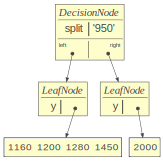

In [10]:
treeviz(t)

### Tweak last rent price to bring inline

We get a different split

In [11]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,1300]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,1300


find_best_split in x=[750, 800, 850, 900, 950]
[1160] | [1200 1280 1450 1300]    candidate split x = 800 loss  16337.5
[1160 1200] | [1280 1450 1300]    candidate split x = 850 loss   9033.3
[1160 1200 1280] | [1450 1300]    candidate split x = 900 loss   9358.3
[1160 1200 1280 1450] | [1300]    candidate split x = 950 loss  24737.5


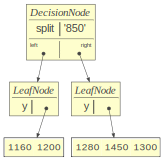

In [12]:
t = fit(df.sqfeet, df.rent)
treeviz(t)

## Visual partitioning of stump via dtreeviz

See [dtreeviz](https://github.com/parrt/dtreeviz).

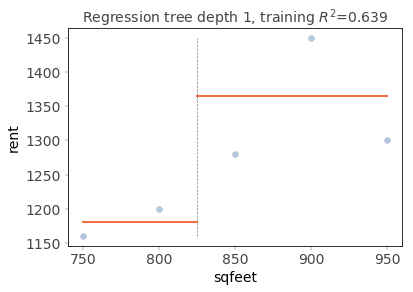

In [13]:
fig = plt.figure()
ax = fig.gca()
X, y = df.sqfeet, df.rent
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=1,
                    feature_name='sqfeet',
                    target_name='rent',
                    fontsize=14)
plt.show()

## Visual partitioning of stump nodes

/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


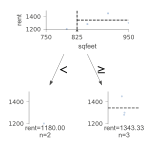

In [14]:
regr = DecisionTreeRegressor(max_depth=1)

X, y = df.sqfeet.values.reshape(-1,1), df.rent
regr = regr.fit(X, y)
viz = dtreeviz(regr, X, y, target_name='rent',
               feature_names=['sqfeet'],
               fancy=True)
#viz.view() # to pop up outside of notebook
viz

# Full regression tree fit

In [17]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    if len(x)==1:
        return LeafNode(y)
    loss, split = find_best_split(x,y)
    if split==-1:
        return LeafNode(y)
    t = DecisionNode(split)
    left = x[x<split]
    right = x[x>=split]
    t.left = fit(left, y[x<split])
    t.right = fit(right, y[x>=split])
    return t

In [22]:
df = pd.DataFrame()
df["x"] = [700, 100, 200, 600, 800]
df["y"] = [10, 2, 3, 11, 9]
df

,x,y
0,700,10
1,100,2
2,200,3
3,600,11
4,800,9


find_best_split in x=[700, 100, 200, 600, 800]
[2] | [10  3 11  9]    candidate split x = 200 loss     19.4
[2 3] | [10 11  9]    candidate split x = 600 loss      1.2
[10  2  3 11] | [9]    candidate split x = 800 loss     32.5
find_best_split in x=[100, 200]
[2] | [3]    candidate split x = 200 loss      0.0
find_best_split in x=[700, 600, 800]
[10 11] | [9]    candidate split x = 800 loss      0.2
find_best_split in x=[700, 600]


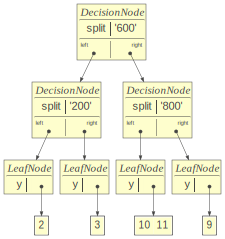

In [23]:
t = fit(df.x, df.y)
treeviz(t)